In [1]:
import mediapipe as mp
import cv2
import numpy as np

2024-11-20 16:00:28.810006: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732096828.880047    8135 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732096828.901428    8135 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 16:00:29.060265: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def extract_keypoints(video_path):
    mp_holistic = mp.solutions.holistic
    holistic = mp_holistic.Holistic(static_image_mode=False)

    cap = cv2.VideoCapture(video_path)
    keypoints = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = holistic.process(frame_rgb)

        if results.pose_landmarks:
            pose = np.array([[lm.x, lm.y, lm.z]
                            for lm in results.pose_landmarks.landmark]).flatten()
            keypoints.append(pose)
        else:
            keypoints.append(np.zeros(99))  # Placeholder for missing data

    cap.release()
    return np.array(keypoints)

In [3]:
# Example Usage
keypoints = extract_keypoints('assets/00623.mp4')

libEGL warning: MESA-LOADER: failed to open radeonsi: /usr/lib/dri/radeonsi_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open radeonsi: /usr/lib/dri/radeonsi_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open zink: /usr/lib/dri/zink_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open radeonsi: /usr/lib/dri/radeonsi_dri.so: cannot o

In [4]:
keypoints

array([[ 4.93967682e-01,  2.40804911e-01, -9.11833167e-01, ...,
         3.93469214e-01,  1.96432006e+00,  3.95695232e-02],
       [ 4.94026184e-01,  2.39637434e-01, -9.07192349e-01, ...,
         3.96422923e-01,  1.99628389e+00,  7.46877044e-02],
       [ 4.94107813e-01,  2.38996997e-01, -8.94222438e-01, ...,
         3.98508221e-01,  2.01170254e+00,  7.99385756e-02],
       ...,
       [ 4.73799169e-01,  2.55863518e-01, -9.27184284e-01, ...,
         3.92260432e-01,  2.03624654e+00, -4.04477082e-02],
       [ 4.73641217e-01,  2.55992055e-01, -9.25022304e-01, ...,
         3.92394215e-01,  2.03770661e+00,  5.29028289e-03],
       [ 4.73508447e-01,  2.56145954e-01, -9.24704731e-01, ...,
         3.92450988e-01,  2.03731132e+00, -6.90121029e-04]])

In [5]:
import tensorflow as tf
from tensorflow.keras import layers

In [6]:
# Encoder: Process English Text


def create_encoder(vocab_size, embedding_dim, encoder_units):
    model = tf.keras.Sequential([
        layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        layers.LSTM(encoder_units, return_sequences=True, return_state=True)
    ])
    return model

# Decoder: Generate Keypoints


def create_decoder(output_dim, decoder_units):
    model = tf.keras.Sequential([
        layers.LSTM(decoder_units, return_sequences=True),
        layers.Dense(output_dim)  # Output keypoints
    ])
    return model

# Combined Model


def build_sign_language_model(vocab_size, embedding_dim, encoder_units, decoder_units, output_dim):
    encoder = create_encoder(vocab_size, embedding_dim, encoder_units)
    decoder = create_decoder(output_dim, decoder_units)

    # Input layers
    text_input = layers.Input(shape=(None,), name="text_input")
    decoder_input = layers.Input(
        shape=(None, output_dim), name="decoder_input")

    # Encoding text
    encoder_output, state_h, state_c = encoder(text_input)

    # Decoding into keypoints
    decoder_output = decoder(decoder_input, initial_state=[state_h, state_c])

    return tf.keras.Model(inputs=[text_input, decoder_input], outputs=decoder_output)

In [7]:
# Example Model
vocab_size = 5000
embedding_dim = 128
encoder_units = 256
decoder_units = 256
output_dim = 99  # 33 joints × 3 (x, y, z)

In [10]:
from tensorflow.keras import layers, Model


def create_decoder(output_dim, decoder_units):
    # Decoder input
    decoder_input = layers.Input(
        shape=(None, output_dim), name="decoder_input")
    initial_state_h = layers.Input(
        shape=(decoder_units,), name="initial_state_h")
    initial_state_c = layers.Input(
        shape=(decoder_units,), name="initial_state_c")

    # LSTM with explicit state passing
    lstm_output, state_h, state_c = layers.LSTM(
        decoder_units,
        return_sequences=True,
        return_state=True
    )(decoder_input, initial_state=[initial_state_h, initial_state_c])

    # Dense layer for generating keypoints
    output = layers.Dense(output_dim)(lstm_output)

    return Model(
        inputs=[decoder_input, initial_state_h, initial_state_c],
        outputs=[output, state_h, state_c],
        name="decoder"
    )

# Adjusting the build function


def build_sign_language_model(vocab_size, embedding_dim, encoder_units, decoder_units, output_dim):
    # Encoder
    encoder = create_encoder(vocab_size, embedding_dim, encoder_units)

    # Decoder
    decoder = create_decoder(output_dim, decoder_units)

    # Input layers
    text_input = layers.Input(shape=(None,), name="text_input")
    decoder_input = layers.Input(
        shape=(None, output_dim), name="decoder_input")

    # Encode text input
    encoder_output, state_h, state_c = encoder(text_input)

    # Decode using initial states from encoder
    decoder_output, _, _ = decoder([decoder_input, state_h, state_c])

    # Build the full model
    return Model(inputs=[text_input, decoder_input], outputs=decoder_output)


# Example usage
model = build_sign_language_model(
    vocab_size, embedding_dim, encoder_units, decoder_units, output_dim)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, None, 99)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ [(None, None,     │  1,034,240 │ text_input[0][0]  │
│ (Sequential)        │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ [(None, None,     │    389,987 │ decoder_input[0]… │
│ (Functional)        │ 99), (None, 256), │            │ sequential_4[0][… │
│                     │ (None, 256)]      │            │ sequential_4[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,424,227 (5.43 MB)

 Trainable params: 1,424,227 (5.43 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Mock Data for Demonstration
import numpy as np

english_text = np.random.randint(1, vocab_size, size=(
    32, 10))  # Batch of 32, sequence length 10
# Batch of 32, sequence length 20, 99 keypoints
keypoints_sequences = np.random.rand(32, 20, output_dim)

# Define Loss and Optimizer
model.compile(optimizer='adam', loss='mse')

# Train
model.fit(
    [english_text, keypoints_sequences[:, :-1, :]],
    keypoints_sequences[:, 1:, :],
    epochs=10,
    batch_size=16
)

Epoch 1/10


/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['text_input', 'decoder_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(
I0000 00:00:1732098008.313531    9634 cuda_dnn.cc:529] Loaded cuDNN version 90300


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3153
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1635 
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1192 
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1073 
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1030 
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0987 
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0937 
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0897 
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0872 
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0869 


In [12]:
def generate_keypoints(model, text_sequence, max_length):
    input_sequence = np.array([text_sequence])  # Add batch dimension
    # Start token (empty keypoint)
    keypoints_sequence = np.zeros((1, 1, output_dim))

    for _ in range(max_length):
        prediction = model.predict(
            [input_sequence, keypoints_sequence], verbose=0)
        keypoints_sequence = np.concatenate(
            [keypoints_sequence, prediction[:, -1:, :]], axis=1)

    return keypoints_sequence[0]


# Example Inference
text_sequence = np.random.randint(1, vocab_size, size=(10,))
generated_keypoints = generate_keypoints(model, text_sequence, max_length=20)

In [13]:
text_sequence, generated_keypoints

(array([3282, 2713,  582, 2045,  549, 2545, 4712, 1409, 4410, 1902]),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.51024133, 0.33949855, 0.32888994, ..., 0.50352985, 0.47490782,
         0.5343734 ],
        [0.50718689, 0.39408597, 0.39167035, ..., 0.49035475, 0.47822681,
         0.52500576],
        ...,
        [0.47353718, 0.50505549, 0.44880918, ..., 0.45644358, 0.49418601,
         0.49555477],
        [0.47354797, 0.50535214, 0.44883105, ..., 0.45664719, 0.49433011,
         0.49557447],
        [0.47357416, 0.50560337, 0.44886413, ..., 0.45682824, 0.49445432,
         0.49560305]]))

In [14]:
keypoints

array([[ 4.93967682e-01,  2.40804911e-01, -9.11833167e-01, ...,
         3.93469214e-01,  1.96432006e+00,  3.95695232e-02],
       [ 4.94026184e-01,  2.39637434e-01, -9.07192349e-01, ...,
         3.96422923e-01,  1.99628389e+00,  7.46877044e-02],
       [ 4.94107813e-01,  2.38996997e-01, -8.94222438e-01, ...,
         3.98508221e-01,  2.01170254e+00,  7.99385756e-02],
       ...,
       [ 4.73799169e-01,  2.55863518e-01, -9.27184284e-01, ...,
         3.92260432e-01,  2.03624654e+00, -4.04477082e-02],
       [ 4.73641217e-01,  2.55992055e-01, -9.25022304e-01, ...,
         3.92394215e-01,  2.03770661e+00,  5.29028289e-03],
       [ 4.73508447e-01,  2.56145954e-01, -9.24704731e-01, ...,
         3.92450988e-01,  2.03731132e+00, -6.90121029e-04]])

In [17]:
np.abs(generated_keypoints - keypoints[0:21])

array([[0.49396768, 0.24080491, 0.91183317, ..., 0.39346921, 1.96432006,
        0.03956952],
       [0.01621515, 0.09986112, 1.23608229, ..., 0.10710692, 1.52137607,
        0.4596857 ],
       [0.01307908, 0.15508898, 1.28589278, ..., 0.09184653, 1.53347573,
        0.44506718],
       ...,
       [0.0150122 , 0.2341781 , 1.47989014, ..., 0.06872249, 1.4799054 ,
        0.20533919],
       [0.0139288 , 0.23467803, 1.3252686 , ..., 0.06875744, 1.47905368,
        0.20458931],
       [0.01363721, 0.23506191, 1.22405824, ..., 0.06870544, 1.47476846,
        0.24197316]])

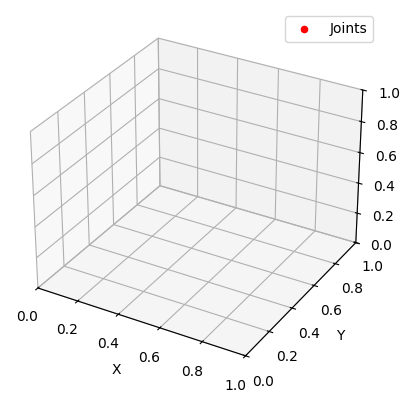

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Simulated data for keypoints
sequence_length = 20
num_joints = 33
# Shape: (sequence_length, num_joints, 3)
keypoints = np.random.rand(sequence_length, num_joints, 3)

# Skeleton connections
connections = [
    (0, 1), (1, 2), (2, 3),  # Example: Head to spine
    (4, 5), (5, 6),          # Example: Left arm
    (8, 9), (9, 10),         # Example: Right arm
    # Add more based on your model
]

# Setup plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter([], [], [], c='r', label='Joints')
lines = [ax.plot([], [], [], 'b')[0] for _ in connections]

# Set plot limits and labels
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

# Initialization function


def init():
    scatter._offsets3d = ([], [], [])
    for line in lines:
        line.set_data([], [])
        line.set_3d_properties([])
    return [scatter, *lines]

# Update function


def update(frame):
    joints = keypoints[frame]  # Shape: (num_joints, 3)

    # Update joints
    scatter._offsets3d = (joints[:, 0], joints[:, 1], joints[:, 2])

    # Update connections
    for idx, (start, end) in enumerate(connections):
        x = [joints[start, 0], joints[end, 0]]
        y = [joints[start, 1], joints[end, 1]]
        z = [joints[start, 2], joints[end, 2]]
        lines[idx].set_data(x, y)
        lines[idx].set_3d_properties(z)

    return [scatter, *lines]


# Create the animation
ani = FuncAnimation(fig, update, frames=sequence_length,
                    init_func=init, blit=True)

# Display animation
plt.show()

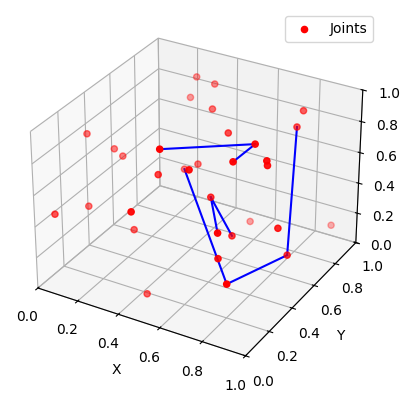

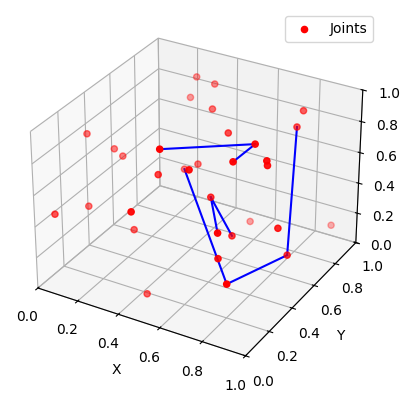

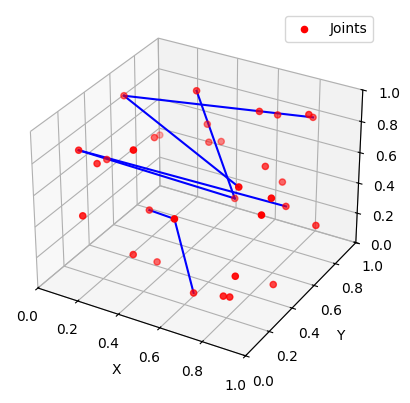

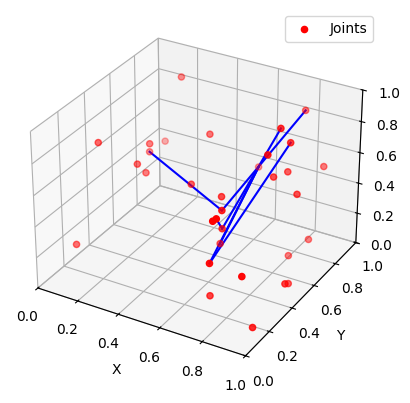

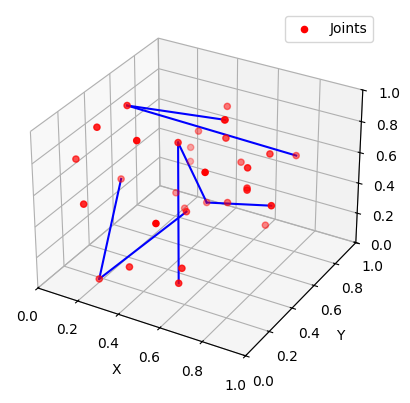

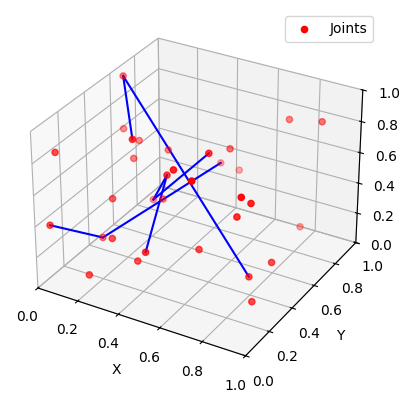

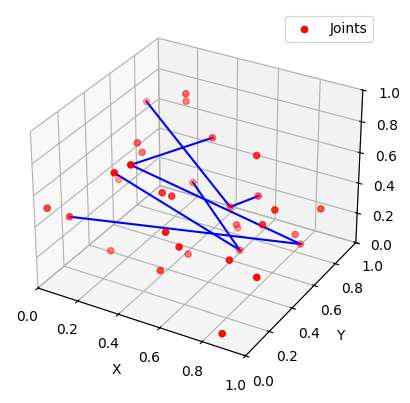

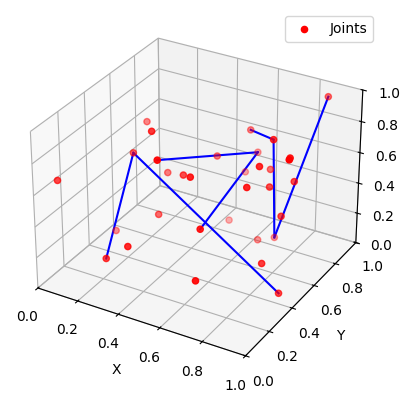

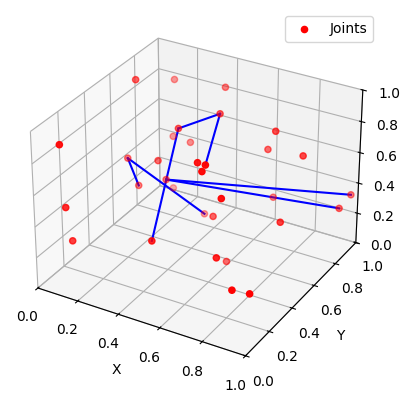

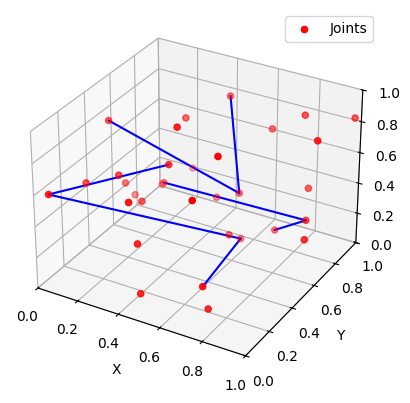

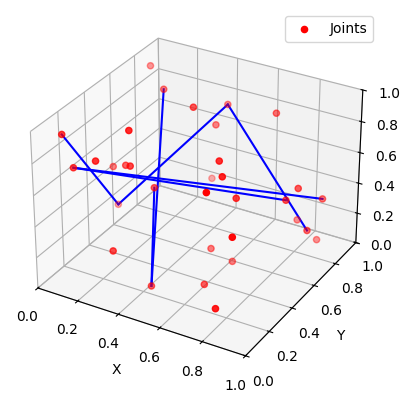

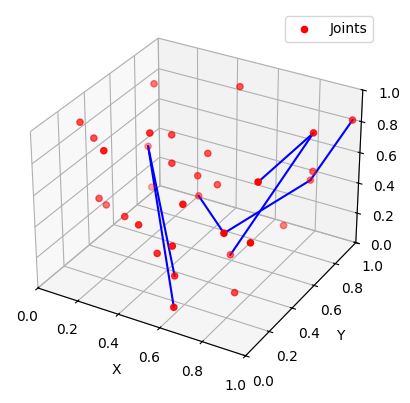

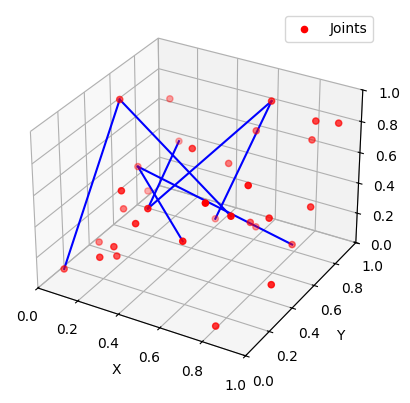

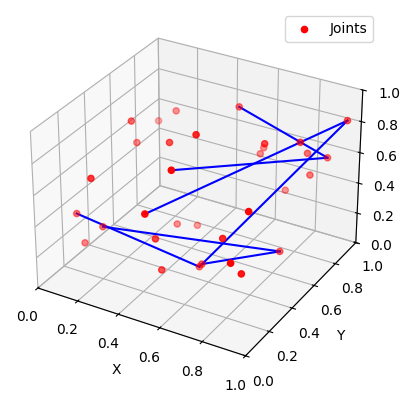

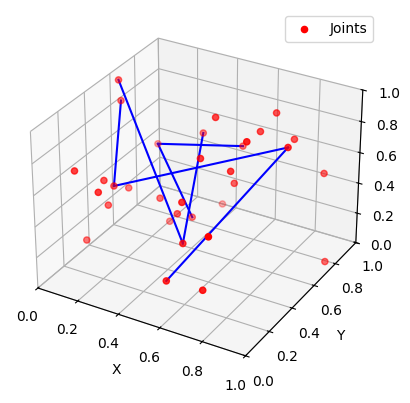

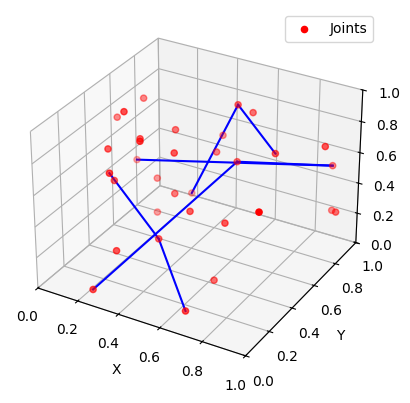

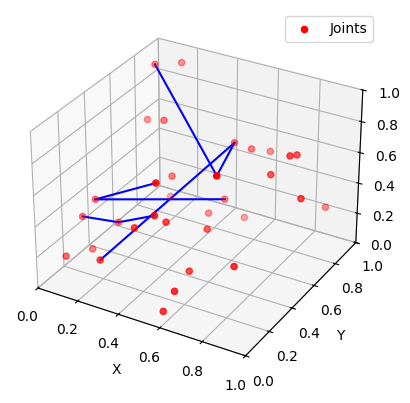

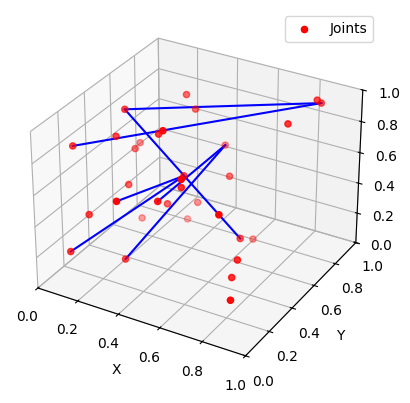

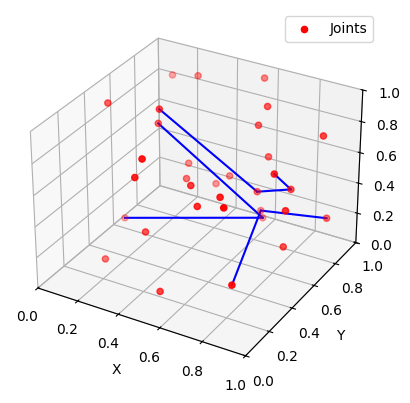

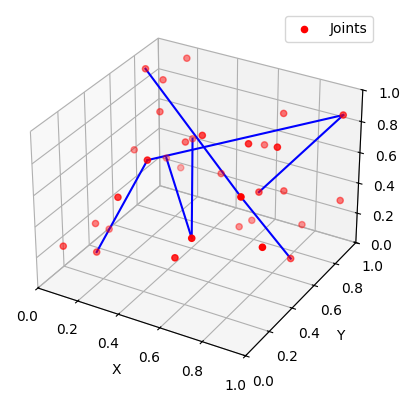

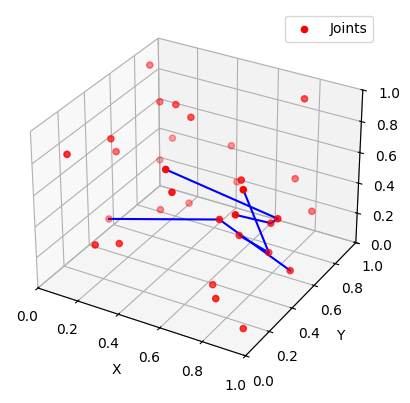

In [22]:
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Example keypoints (Replace this with your actual data)
# Shape: (sequence_length, num_joints * 3)
sequence_length = 20
num_joints = 33
keypoints = np.random.rand(sequence_length, num_joints * 3)

# Joint connections (for a skeleton-like appearance)
connections = [
    (0, 1), (1, 2), (2, 3),  # Example: Head to spine
    (4, 5), (5, 6),          # Left arm
    (8, 9), (9, 10),         # Right arm
    # Add more based on your model (e.g., OpenPose or MediaPipe connections)
]

# Visualize each frame


def visualize_frame(keypoints_frame):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Extract joint positions
    joints = keypoints_frame.reshape(-1, 3)  # Shape: (num_joints, 3)

    # Scatter plot for joints
    ax.scatter(joints[:, 0], joints[:, 1], joints[:, 2], c='r', label='Joints')

    # Draw bones (connections)
    for start, end in connections:
        x = [joints[start, 0], joints[end, 0]]
        y = [joints[start, 1], joints[end, 1]]
        z = [joints[start, 2], joints[end, 2]]
        ax.plot(x, y, z, 'b')  # Bone connection

    # Set plot limits and labels
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()


# Visualize a single frame (e.g., the first frame)
visualize_frame(keypoints[0])

# Visualize the entire sequence as an animation

for i in range(sequence_length):
    visualize_frame(keypoints[i])
    time.sleep(0.1)  # Pause between frames